In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from mpc import mpc
from mpc.mpc import QuadCost, LinDx, GradMethods

In [10]:
N = 1
Ns = 4
Na = 4
T = 10
dt = 0.1              # TODO get val from env
tau = 0.25            # TODO get val from env
eps = 1e-3
size = 0.075
max_speed = None
sensitivity = 5.
Tsim = 50
batch_size = 128
LQR_ITER = 300

In [11]:
# dynamics of 1 single agent
A1 = torch.tensor([[0, 0, 1, 0], 
              [0, 0, 0, 1], 
              [0, 0, -tau/dt, 0], 
              [0, 0, 0, -tau/dt]])
B1 = torch.tensor([[0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [1, -1, 0, 0], 
              [0, 0, 1, -1]]) 
# discrete dynamics
Ad = torch.eye(A1.shape[0]) + A1*dt
Bd = B1*dt*sensitivity
# extend dynamics oevr horizon and batch size
A = Ad.repeat(T, batch_size, 1, 1)
B = Bd.repeat(T, batch_size, 1, 1)
Fd = torch.cat((A, B), dim=3)



In [12]:
# init 
u_init = None
x_init = torch.rand((batch_size, Ns))

x_history = [torch.unsqueeze(x_init, -1)]
u_history = []

for i in range(Tsim):
  # Quadratic cost
  xd = -x_init + torch.tensor([0.5, 0.5, 0., 0.]).repeat(batch_size, 1)       # (B, Ns) desired states
  xd[:, 2:] = torch.ones((batch_size, 2)) * 1e-5
  w = torch.tensor([1., 1., 1e-1, 1e-1])                                      # (Ns,) state weights
  q = torch.cat((w, 1e-1 * torch.ones(Na)))                                   # (Ns+Na,) state-action weights
  Q = torch.diag(q).repeat(T, batch_size, 1, 1)                               # (T, B, Ns+Na, Ns+Na) weight matrix
  px = -torch.sqrt(w) * xd                                                    # (B, Ns) linear cost vector
  p = torch.cat((px, 1e-2*torch.ones((batch_size, Na))), 1).repeat(T, 1, 1)   # (T, B, Ns+Na) linear cost vector for state-action
  cost = mpc.QuadCost(Q, p)

  # recreate controller using updated u_init (kind of wasteful right?)
  ctrl = mpc.MPC(Ns, Na, T, u_lower=0., u_upper=1., lqr_iter=LQR_ITER,
                exit_unconverged=True, eps=1e-2,
                n_batch=batch_size, backprop=True, verbose=0, u_init=u_init,
                grad_method=mpc.GradMethods.AUTO_DIFF)
  # compute action based on current state, dynamics, and cost
  x0 = torch.cat((torch.zeros(batch_size, 2), x_init[:, 2:]), 1)
  nominal_states, nominal_actions, nominal_objs = ctrl(x0, cost, LinDx(Fd))
  action = nominal_actions[0]  # take first planned action  
  # propagate state
  x_init = torch.matmul(Fd, torch.unsqueeze(torch.cat((x_init, action), dim=1), -1)).squeeze(-1)[0]
  # store state and action
  x_history.append(torch.unsqueeze(x_init, -1))
  u_init = torch.cat((nominal_actions[1:], torch.zeros(1, batch_size, Na)), dim=0)
  u_history.append(torch.unsqueeze(action, -1))

x_history = torch.cat(x_history, -1)
u_history = torch.cat(u_history, -1)

Text(0.5, 0, 'x')

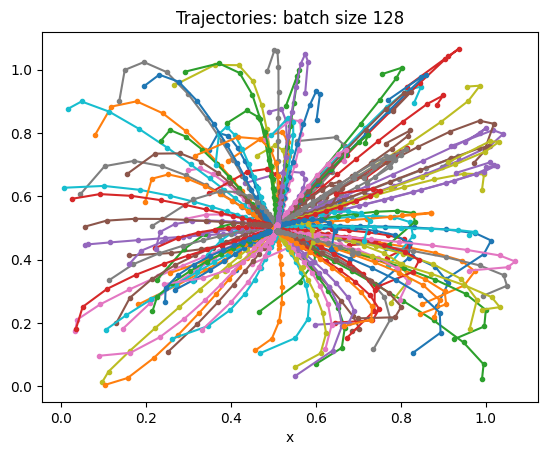

In [13]:
for i in range(batch_size):
  plt.plot(x_history[i, 1, :], x_history[i, 0, :], '.-')
plt.title(f"Trajectories: batch size {batch_size}")
plt.xlabel("y")
plt.xlabel("x")

Text(0, 0.5, 'y position')

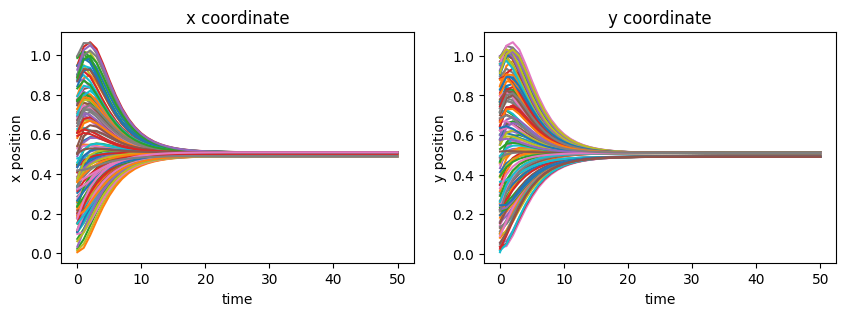

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
for i in range(batch_size):
  ax[0].plot(torch.arange(0, Tsim+1), x_history[i, 0, :])
  ax[1].plot(torch.arange(0, Tsim+1), x_history[i, 1, :])
ax[0].set_title("x coordinate")
ax[1].set_title("y coordinate")
ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
ax[0].set_ylabel("x position")
ax[1].set_ylabel("y position")

Text(0, 0.5, 'v_y')

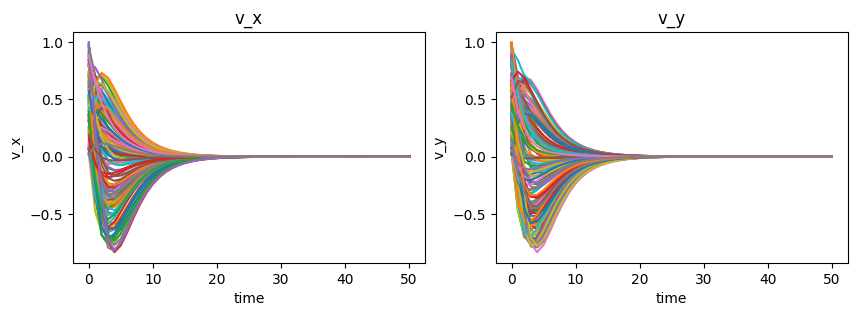

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
for i in range(batch_size):
  ax[0].plot(torch.arange(0, Tsim+1), x_history[i, 2, :])
  ax[1].plot(torch.arange(0, Tsim+1), x_history[i, 3, :])
ax[0].set_title("v_x")
ax[1].set_title("v_y")
ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
ax[0].set_ylabel("v_x")
ax[1].set_ylabel("v_y")

Text(0, 0.5, 'u_3')

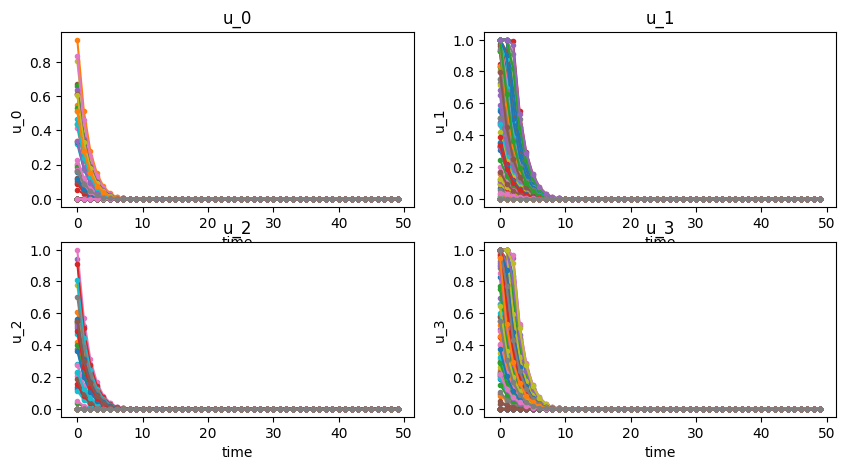

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10,5))
for i in range(batch_size):
  ax[0][0].plot(torch.arange(0, Tsim), u_history[i, 0, :], '.-')
  ax[0][1].plot(torch.arange(0, Tsim), u_history[i, 1, :], '.-')
  ax[1][0].plot(torch.arange(0, Tsim), u_history[i, 2, :], '.-')
  ax[1][1].plot(torch.arange(0, Tsim), u_history[i, 3, :], '.-')

ax[0][0].set_title("u_0")
ax[0][1].set_title("u_1")
ax[1][0].set_title("u_2")
ax[1][1].set_title("u_3")
ax[0][0].set_xlabel("time")
ax[0][1].set_xlabel("time")
ax[1][0].set_xlabel("time")
ax[1][1].set_xlabel("time")
ax[0][0].set_ylabel("u_0")
ax[0][1].set_ylabel("u_1")
ax[1][0].set_ylabel("u_2")
ax[1][1].set_ylabel("u_3")